$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\renewcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\grad}[0]{\nabla}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\Var}[1]{\mathrm{Var}\left[#1\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[0]{\middle\vert}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\trace}{trace}
\newcommand{\1}[1]{\mathbb{I}\left\{#1\right\}}
\newcommand{\setof}[1]{\left\{#1\right\}}
\newcommand{\DO}[1]{\mathrm{do}\left(#1\right)}
\newcommand{\indep}{\perp \!\!\! \perp}
$$


# <center>Causal Inference 097400, Winter 2019-20<br><br>Final Project</center>

#### <center>Aviv Rosenberg<br>`avivr@cs`</center>

##### <center>April, 2020<br></center>


In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd

PHYSIONET_DB = 'data/physionet/crisdb'
MHRV_DATA_FILE = 'data/crisdb-full-60min.xlsx'
OUT_DIR = 'out/'

os.makedirs(OUT_DIR, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
plt.rcParams['font.size'] = 12

## Part 1: Creating the datasets

In [3]:
from proj import data
from proj import ci

Load metadata from the PhysioNet CASTRR database files.

In [4]:
df_meta = data.castrr_load_metadata(PHYSIONET_DB)
df_meta.head()

,AGE,SEX
rec,,
e001a,60,Male
e001b,60,Male
e002a,65,Male
e002b,65,Male
e003a,55,Male


Load the HRV features calculated on this database with `mhrv`.
Then, join the HRV features with the metadata.

In [6]:
MHRV_GROUP_NAMES = ['E_CONTROL', 'E_TREATED', 'F_CONTROL', 'F_TREATED', 'M_CONTROL', 'M_TREATED']
dfs = data.load_mhrv_xls(MHRV_DATA_FILE, sheet_names=MHRV_GROUP_NAMES, df_meta=df_meta)

for name, df in dfs.items():
    assert not np.any(pd.isna(df)), name

Loaded E_CONTROL: 5937 samples, 49 features
Loaded E_TREATED: 6018 samples, 49 features
Loaded F_CONTROL: 4617 samples, 49 features
Loaded F_TREATED: 4760 samples, 49 features
Loaded M_CONTROL: 6137 samples, 49 features
Loaded M_TREATED: 6337 samples, 49 features


In [7]:
dfs['E_CONTROL']

RR    NN        AVNN       SDNN      RMSSD     pNN50       SEM  \
rec   win                                                                     
e001a 1    4327  4264  701.071106  41.581642  13.757771  0.234577  0.636785   
      2    4477  4404  750.743286  49.516403  15.641404  0.408812  0.746149   
      3    4722  4650  722.733521  59.652050  14.098043  0.150570  0.874780   
      4    4769  4696  703.978455  53.346508  13.653588  0.255591  0.778470   
      5    4986  4922  687.711121  47.553204  12.772495  0.386100  0.677812   
...         ...   ...         ...        ...        ...       ...       ...   
e286a 16   4840  4819  739.530396  29.074734  10.354865  0.020755  0.418830   
      17   5289  5213  666.909973  41.037853  10.034287  0.095932  0.568383   
      18   5374  5355  667.397583  23.006018  11.370922  0.261487  0.314385   
      19   4924  4856  719.261597  22.993504  10.629254  0.082389  0.329963   
      20   5130  4992  681.668823  20.523258  11.011402  0.080144  0.290475   

            BETA_AR  HF_NORM_AR  HF_PEAK_AR  ...     MSE17     MSE18  \
rec   win                                    ...                       
e001a 1   -1.117969    7.328302    0.327401  ...  1.348242  1.395579   
      2   -1.128235    5.956380    0.254147  ...  1.307543  1.354694   
      3   -1.095494    6.322984    0.252652  ...  1.222841  1.239768   
      4   -1.121374    4.156405    0.255642  ...  1.251534  1.125110   
      5   -1.179842    4.143440    0.240692  ...  1.444636  1.419865   
...             ...         ...         ...  ...       ...       ...   
e286a 16  -0.414241    5.571465    0.346089  ...  1.133445  1.180290   
      17  -0.682378    7.548707    0.325159  ...  0.673941  0.681831   
      18  -1.036899   12.584630    0.319926  ...  0.906764  0.942591   
      19  -0.436453    9.975235    0.269097  ...  1.371525  1.503135   
      20  -0.862907   14.472836    0.387948  ...  1.178824  1.134544   

              MSE19     MSE20        PIP      IALS        PSS        PAS  AGE  \
rec   win                                                                       
e001a 1    1.477925  1.502828  30.816135  0.308468  19.723265   6.191370   60   
      2    1.323236  1.371318  34.196186  0.342267  25.272480   8.969119   60   
      3    1.133098  1.205776  30.537634  0.305657  20.021505   7.118279   60   
      4    1.228755  1.128171  31.856899  0.318850  21.869677   6.984668   60   
      5    1.398180  1.431729  28.728159  0.287543  18.468102   5.099553   60   
...             ...       ...        ...       ...        ...        ...  ...   
e286a 16   1.206903  1.167605  38.659473  0.386883  29.196928  15.646399   65   
      17   0.705784  0.639730  40.053711  0.400806  29.100327  15.288701   65   
      18   0.936589  1.025636  42.689075  0.427157  33.053223  18.169935   65   
      19   1.390089  1.548041  38.632618  0.386612  28.644976  14.229818   65   
      20   1.174832  1.112965  41.646633  0.416750  31.951122  16.326122   65   

              SEX  
rec   win          
e001a 1      Male  
      2      Male  
      3      Male  
      4      Male  
      5      Male  
...           ...  
e286a 16   Female  
      17   Female  
      18   Female  
      19   Female  
      20   Female  

[5937 rows x 49 columns]

Now we'll add the outcome columns. We'll use the non-linear HRV features as the outcomes, which measure the type of dynamics found in the heart beat intervals.

Note that for the treated group, the outcomes must come from the post-treatment data.
However, we'll take the pre-treatment HRV features for the treated group.

In [130]:
datasets = {}
for drug in ['E', 'F', 'M']:
    df_ci = data.castrr_ci_dataset(
        dfs[f'{drug}_CONTROL'], dfs[f'{drug}_TREATED'],
        ignore_features=['SampEn'],
        include_counterfactuals=True,
        random_seed=None
    )
    df_ci.to_csv(f'{OUT_DIR}/df_ci_{drug}.csv')
    assert not np.any(pd.isna(df_ci))
    datasets[drug] = df_ci

In [132]:
for name, df in datasets.items():
    print(f'*** {name} dataset: ', end='')
    X, y, t = data.split_dataset(df, scale_covariates=True)
    print(f'X{X.shape}, y{y.shape}, t{t.shape}')

*** E dataset: X(5274, 25), y(5274, 10), t(5274,)
*** F dataset: X(4119, 25), y(4119, 10), t(4119,)
*** M dataset: X(5621, 25), y(5621, 10), t(5621,)


In [133]:
df_ci.iloc[:10,24:]

X_SEX  Y_MSE_LO  Y_MSE_HI  Y_ALPHA1  Y_ALPHA2    Y_BETA  Y_MSE_LO_CF  \
rec  win                                                                        
m001 1    Male  1.221024  1.258269  1.506210  0.941056  0.619776     1.211795   
     2    Male  1.270886  1.534713  1.500880  1.029804  0.873503     1.263753   
     3    Male  1.271279  1.311563  1.496287  1.046103  1.071471     0.749420   
     4    Male  1.685946  1.497039  1.477300  0.804598  0.617146     1.149778   
     5    Male  1.633407  1.527631  1.423625  0.906414  0.541804     0.503117   
     6    Male  1.634700  1.520417  1.433962  0.968587  0.794617     0.859226   
     7    Male  1.398691  1.461179  1.426832  0.995256  0.784087     0.816836   
     8    Male  1.720966  1.644875  1.472834  0.832979  0.688137     0.539233   
     9    Male  1.547705  1.524019  1.524022  0.802087  0.647327     0.425330   
     10   Male  1.195838  1.148776  1.487602  0.942565  0.836086     0.754664   

          Y_MSE_HI_CF  Y_ALPHA1_CF  Y_ALPHA2_CF  Y_BETA_CF  T  
rec  win                                                       
m001 1       1.396972     1.515723     1.068752   0.829538  0  
     2       1.391331     1.438323     1.165637   1.040624  0  
     3       0.861492     1.435941     1.366135   1.602573  0  
     4       1.259945     1.380110     0.977871   0.678313  0  
     5       0.645302     1.442483     1.129825   1.204562  0  
     6       0.859353     1.501232     1.059057   0.604164  0  
     7       1.016236     1.580708     1.229488   0.888618  0  
     8       0.756516     1.542149     1.246684   0.975170  0  
     9       0.394858     1.662192     1.258137   0.764251  0  
     10      0.878619     1.498455     1.303012   1.101889  0

### Exploring the data

Let's plot the distribution of the data in the outcome variables of interest, conditioned on the treatment.

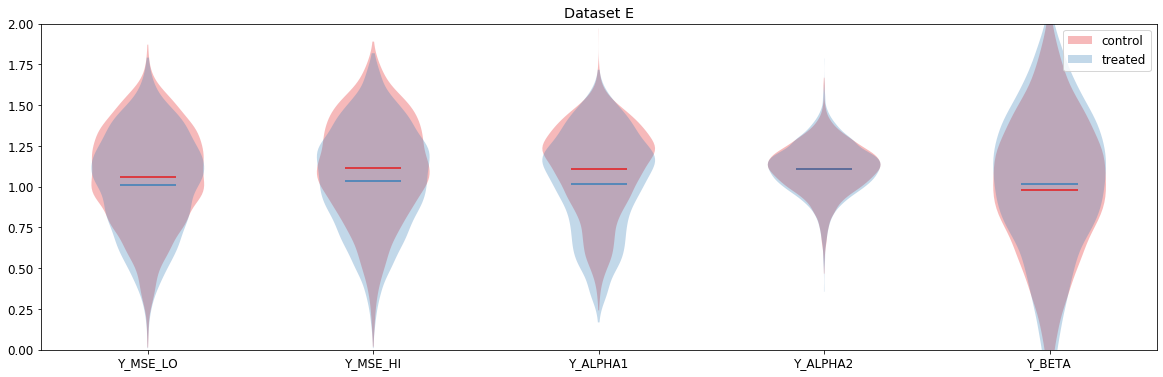

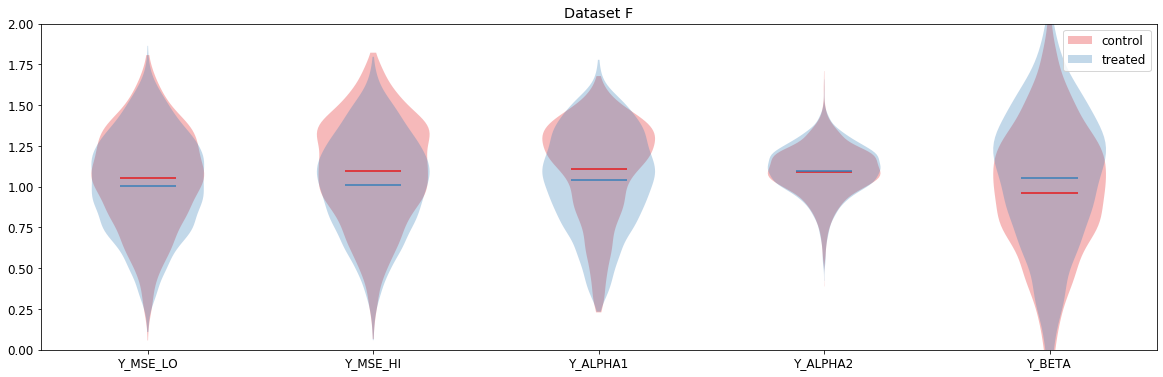

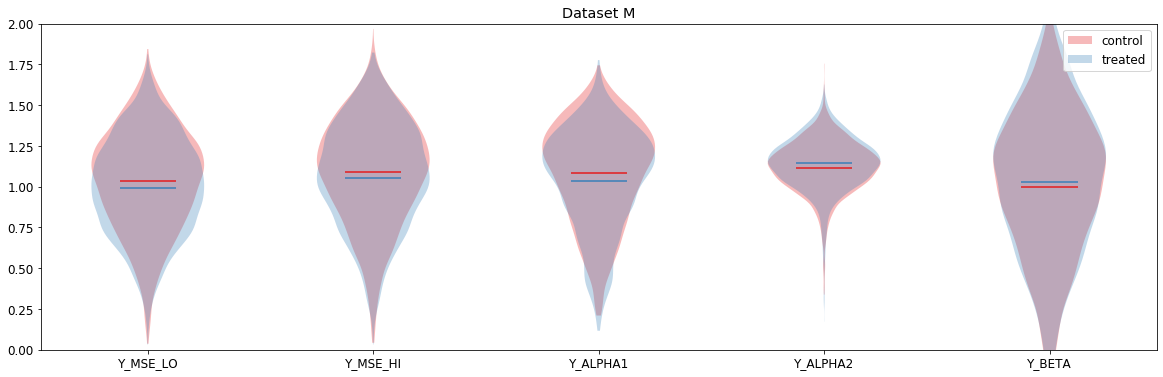

In [134]:
from proj import plot

for i, (name, df) in enumerate(datasets.items()):
    fig, ax = plt.subplots(1, 1, figsize=(20,6))
    group_by = dict(by='T')
    group_legend_names={0: 'control', 1: 'treated'}
    violin_args = dict(showextrema=False, showmeans=True, widths=0.5)
    plot.df_group_violins(ax, df, ['Y_MSE_LO', 'Y_MSE_HI', 'Y_ALPHA1', 'Y_ALPHA2', 'Y_BETA'], group_by, violin_args, group_legend_names)
    ax.set_title(f'Dataset {name}')
    ax.set_ylim(0, 2)

## Part 2: Propensiy estimation and common support

The *propensity score* is defined as $e(\vec{x}):=\Pr{\left(\rvar{T}=1\given \rvec{X}=\vec{x}\right)}$.
In other words, it is the probability that a treatment $\rvar{T}=1$ will be assigned to a
unit with covariates $\rvec{X}=\vec{x}$.
In this case, since our treatment variable is age, it is not really "assigned" based on covariates.
However, the propensity estimation can shed light on whether covariates have predictive power regarding age, and help us achieve balanced covariate marginal distributions for matching.

We would like to obtain an estimator for the propensity score, $\hat e(\vec{x})$, from the data.
One important aspect of this estimator is that we would like it to be *calibrated*.
Briefly, this means that for if for example we look at all units $\vec{x}$ such that $e(\vec{x})=0.8$, we expect 80\% of them to actually belong to the treatment group ($\rvar{T}=1$).

In [135]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from scipy import stats

from proj.ci.cv import CVConfig, LogSpaceSampler

# Define the methods and CV search space for propensity estimation
rcv_config = {
    'logistic': CVConfig(
        model=LogisticRegression(dual=False, solver='liblinear', max_iter=200),
        params=dict(C=LogSpaceSampler(-5, 1), penalty=['l1','l2']),
    ),
    'gbm': CVConfig(
        model=GradientBoostingClassifier(),
        params=dict(
            n_estimators=stats.randint(1, 10 + 1),
            max_depth=stats.randint(1, 2 + 1),
            learning_rate=LogSpaceSampler(-2, 0.5),
        )
    ),
}

E logistic 	best_params={'model__C': 5.848333713948903, 'model__penalty': 'l1'}
F logistic 	best_params={'model__C': 1.7482181544313324, 'model__penalty': 'l1'}
M logistic 	best_params={'model__C': 0.8515837676045575, 'model__penalty': 'l1'}
E gbm 	best_params={'model__learning_rate': 0.26675338306433855, 'model__max_depth': 2, 'model__n_estimators': 9}
F gbm 	best_params={'model__learning_rate': 1.1492066928873486, 'model__max_depth': 2, 'model__n_estimators': 9}
M gbm 	best_params={'model__learning_rate': 0.6533479705456409, 'model__max_depth': 2, 'model__n_estimators': 9}


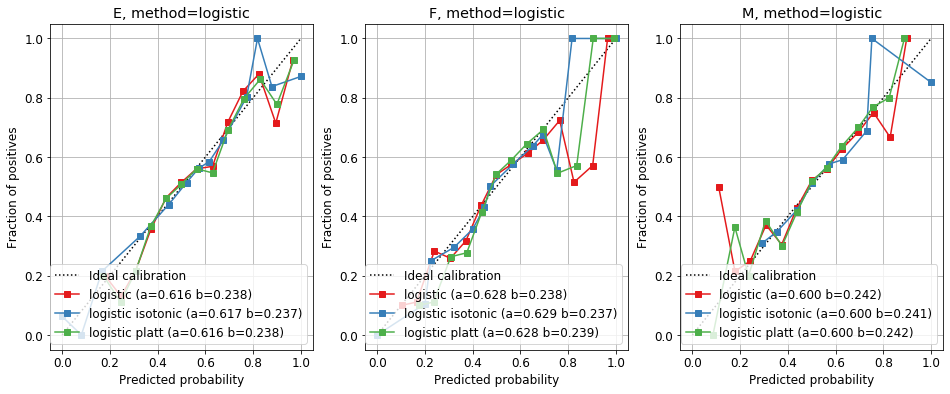

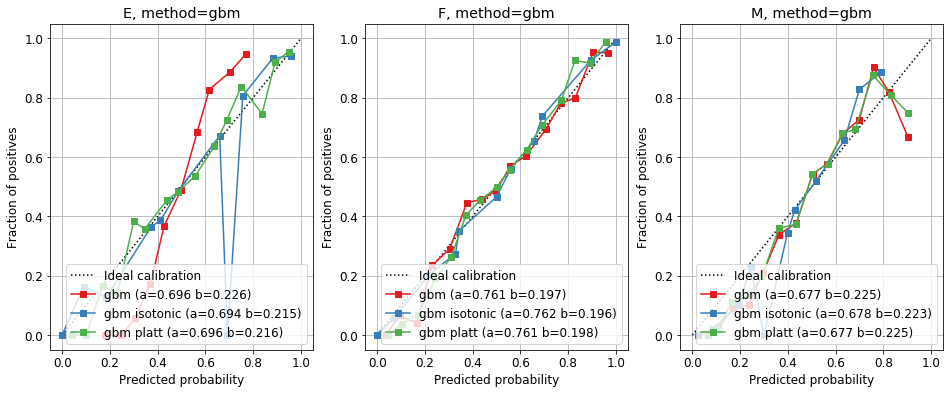

In [136]:
from proj.ci.propensity import fit_propensity_cv

# Create a dataframe to store propensities from each dataset and each method
midx = pd.MultiIndex.from_product([datasets.keys(), rcv_config.keys()], names=['dataset', 'method'])
df_propensity = pd.DataFrame(columns=midx)
dataset_propensities = {}

for method, cv_cfg in rcv_config.items():
    fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(16, 6))
    
    for i, (dataset_name, df) in enumerate(datasets.items()):
        # Get covariates X and treatment assignment t as numpy arrays
        X, _, t = data.split_dataset(df, scale_covariates=True)
        
        # Train a model to estimate propensity using current method,
        # calibrate with two approaches and generate a calibration plot
        model, best_params = fit_propensity_cv(
            cv_cfg, X, t, plot_args=dict(name=method, ax=ax[i]),
            test_size=0.3, n_iter=42, random_state=42+i, cv_splits=4
        )
        
        # Use the best calibrated model (lowest Brier score) to estimate the propensities
        prop = model.predict_proba(X)[:, 1]
#         df_propensity[(dataset_name, method)] = prop
        dataset_propensities[(dataset_name, method)] = prop
        
        ax[i].set_title(f'{dataset_name}, method={method}')
        print(f'{dataset_name} {method} \tbest_params={best_params}')

The plots above show the calibration curves of the logistic regression (top row) and the GBM models (middle row).
The ideal calibration is shown as a dotted line.
For each classifier, two calibration methods, Platt and Isotonic Regression, are shown.
In the legend, both the ROC-AUC score (`a`) and the Brier score (`b`) are reported as measures of the model's
classification performance (higher is better) and de-calibration level (lower is better), respectively.

To visualize the propensity estimation results of each method, we can plot the distribution of propensity scores between treated and control groups.

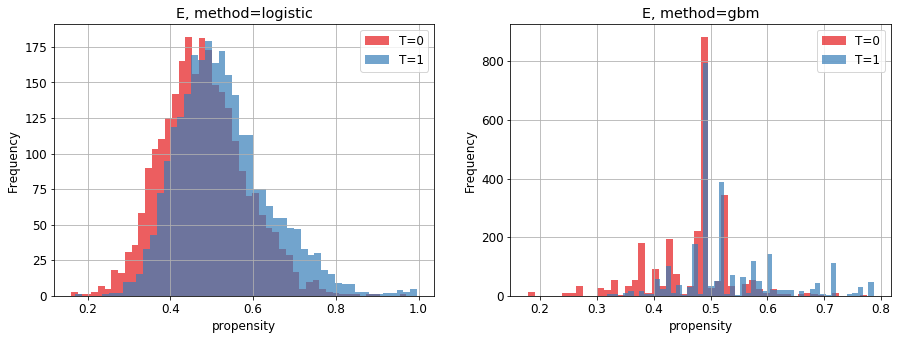

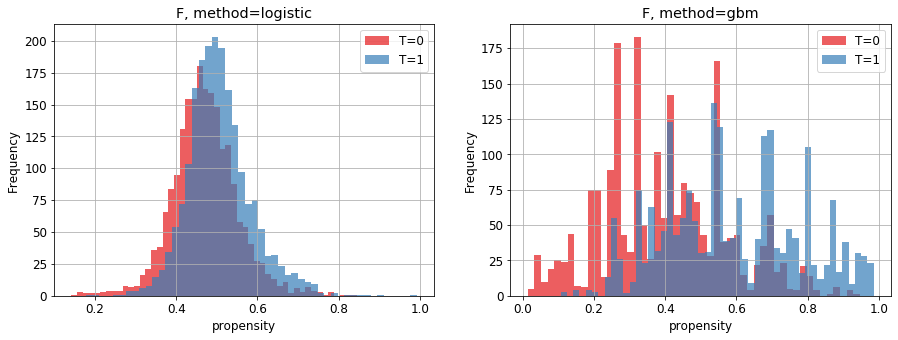

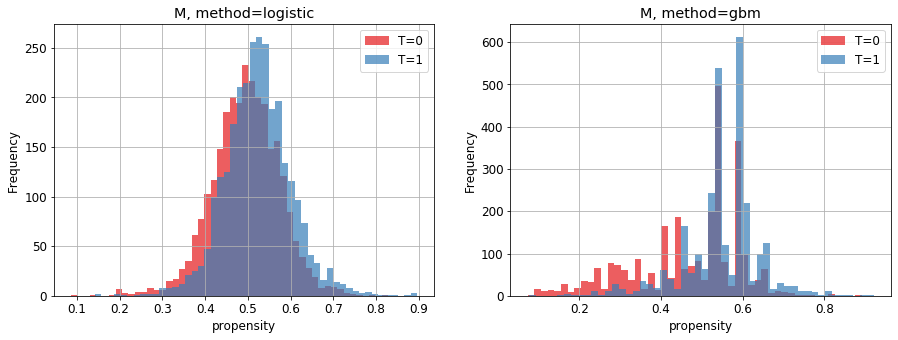

In [137]:
for i, (dataset_name, df) in enumerate(datasets.items()):
    fig, ax = plt.subplots(nrows=1, ncols=len(rcv_config.keys()), figsize=(15, 5))
    # Create a temporaty dataframe
    df_tmp = df.copy()
    
    for j, method in enumerate(rcv_config.keys()):
        # Add propensity from current method to the temporary dataframe
        # df_tmp['propensity'] = df_propensity[(dataset_name, method)].values
        df_tmp['propensity'] = dataset_propensities[(dataset_name, method)]
        # Plot propensity scores conditioned on treatment
        groups = df_tmp.groupby('T')
        groups['propensity'].plot(kind='hist', sharex=True, alpha=0.7, bins=50, ax=ax[j])
        ax[j].set_title(f'{dataset_name}, method={method}')
        ax[j].set_xlabel('propensity'); ax[j].grid(True); ax[j].legend([f'T=0','T=1'])

In order to do causal inference we need the common support ("overlap") assumption to hold:
$$
\forall t,~\vec{x}:\ \Pr\left(\rvar{T}=t\given \rvec{X}=\vec{x}\right)>0.
$$
This means that the the probability of any treatment is possible for any possible covariates of a unit.
In practice we have a limited dataset, and in our specific data this assumption does not hold when
we don't have samples from both groups (treatment and control) within the entire range of propensity scores.
Therefore, to maintain the overlap assumption in our dataset, we'll remove samples for which the propensity
score is outside the range of propensity scores of the other group.
In addition, we'll remove samples with extremely low propensity and high scores as these will cause numerical errors.

The common support calculation is implemented in the `common_support` function within the `propensity.py` module.

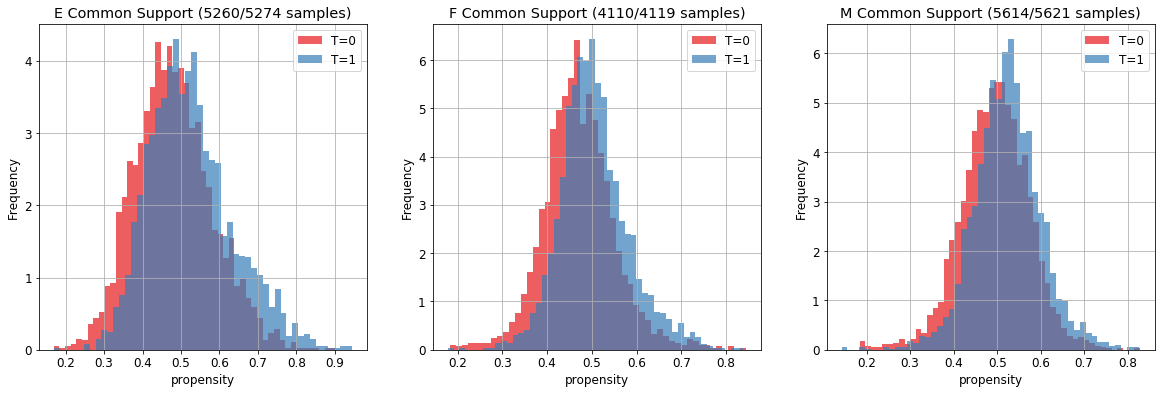

In [146]:
from proj.ci.propensity import common_support

# Select 'logistic' as the propensity method for all datasets
prop_methods = ('logistic', 'logistic', 'logistic')
cs_threshold = 5e-2 # 5%/95%

# We'll save the dataframes after removing samples outside common support
datasets_cs = {}

fig, ax = plt.subplots(nrows=1, ncols=len(datasets), figsize=(20, 6))
for i, (dataset_name, df) in enumerate(datasets.items()):
    # Copy the dataset and add a propesity column based on the selected method
    df = df.copy()
#     df['propensity'] = df_propensity[(dataset_name, prop_methods[i])].values
    df['propensity'] = dataset_propensities[dataset_name, prop_methods[i]]
    
    # Get common support indices and remove outlying samples
    idx_common = common_support(df['T'].to_numpy(), df['propensity'].to_numpy(),
                                min_thresh=cs_threshold, max_thresh=1-cs_threshold)
    df = df[idx_common]
    
    # Save the df with removed samples
    datasets_cs[dataset_name] = df
    
    groups = df.groupby('T')
    groups['propensity'].plot(kind='hist', sharex=True, alpha=0.7, bins=50, ax=ax[i], density=True)
    ax[i].set_xlabel('propensity'); ax[i].grid(True); ax[i].legend([f'T=0','T=1'])
    ax[i].set_title(f'{dataset_name} Common Support ({len(df)}/{len(datasets[dataset_name])} samples)')
    

In [147]:
datasets_cs['E']

X_RR  X_NN      X_AVNN     X_SDNN    X_RMSSD   X_pNN50     X_SEM  \
rec  win                                                                     
e001 1    4327  4264  701.071106  41.581642  13.757771  0.234577  0.636785   
     2    4477  4404  750.743286  49.516403  15.641404  0.408812  0.746149   
     3    4722  4650  722.733521  59.652050  14.098043  0.150570  0.874780   
     4    4769  4696  703.978455  53.346508  13.653588  0.255591  0.778470   
     5    4986  4922  687.711121  47.553204  12.772495  0.386100  0.677812   
...        ...   ...         ...        ...        ...       ...       ...   
e286 16   4840  4819  739.530396  29.074734  10.354865  0.020755  0.418830   
     17   5289  5213  666.909973  41.037853  10.034287  0.095932  0.568383   
     18   5374  5355  667.397583  23.006018  11.370922  0.261487  0.314385   
     19   4924  4856  719.261597  22.993504  10.629254  0.082389  0.329963   
     20   5130  4992  681.668823  20.523258  11.011402  0.080144  0.290475   

          X_HF_NORM  X_HF_PEAK  X_HF_POWER  ...  Y_ALPHA1  Y_ALPHA2    Y_BETA  \
rec  win                                    ...                                 
e001 1     7.328302   0.327401   35.906681  ...  1.397856  1.046907  1.117969   
     2     5.956380   0.254147   47.873642  ...  1.287475  1.153529  1.128235   
     3     6.322984   0.252652   40.273525  ...  1.362086  1.154073  1.095494   
     4     4.156405   0.255642   34.266960  ...  1.441233  1.170381  1.121374   
     5     4.143440   0.240692   28.493835  ...  1.344558  1.200848  1.179842   
...             ...        ...         ...  ...       ...       ...       ...   
e286 16    5.571465   0.346089   11.673881  ...  1.290847  1.225419  0.832931   
     17    7.548707   0.325159   10.404467  ...  1.331122  1.030012 -0.056303   
     18   12.584630   0.319926   12.798417  ...  1.429094  1.105231  0.243508   
     19    9.975235   0.269097   13.217142  ...  1.514911  1.133940  0.494520   
     20   14.472836   0.387948   13.501737  ...  1.307981  1.334617  1.341095   

          Y_MSE_LO_CF  Y_MSE_HI_CF  Y_ALPHA1_CF  Y_ALPHA2_CF  Y_BETA_CF  T  \
rec  win                                                                     
e001 1       0.880031     0.883408     1.122734     1.135432   1.475950  0   
     2       0.947475     1.128733     1.135297     1.189446   1.402955  0   
     3       0.789783     0.864766     1.213596     1.151201   1.372979  0   
     4       1.185201     1.314898     1.319897     1.152796   1.090734  0   
     5       1.097358     1.163188     1.327234     1.111413   1.324924  0   
...               ...          ...          ...          ...        ... ..   
e286 16      1.179550     1.238807     1.448224     0.897997   0.414241  1   
     17      0.394931     0.646713     1.138767     1.227982   0.682378  1   
     18      0.817361     0.924871     0.894756     1.183265   1.036899  1   
     19      1.145182     1.418889     1.153600     1.043443   0.436453  1   
     20      1.034808     1.141971     1.010763     1.008199   0.862907  1   

          propensity  
rec  win              
e001 1      0.359848  
     2      0.369042  
     3      0.366543  
     4      0.350913  
     5      0.295455  
...              ...  
e286 16     0.600445  
     17     0.617118  
     18     0.648895  
     19     0.580852  
     20     0.627295  

[5260 rows x 37 columns]